In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-poster')

In [3]:
# From Covid Tracking API
# https://covidtracking.com/api/
api_us = 'https://covidtracking.com/api/us/daily'
api_states = 'https://covidtracking.com/api/states/daily'

# https://github.com/COVID19Tracking/associated-data
f_pop = 'associated-data/us_census_data/us_census_2018_population_estimates_states.csv'

In [4]:
df_us = pd.read_json(api_us)
df_states = pd.read_json(api_states)
df_pop = pd.read_csv(f_pop)

In [5]:
df_us.shape

(107, 24)

In [6]:
df_states.shape

(3545, 27)

In [7]:
df_pop.head()

,state,state_name,geo_id,population,pop_density
0,AL,Alabama,1,4887871,96.509389
1,AK,Alaska,2,737438,1.291523
2,AZ,Arizona,4,7171646,63.135855
3,AR,Arkansas,5,3013825,57.919684
4,CA,California,6,39557045,253.906502


In [8]:
df_us['date'] = df_us['date'].apply(
    lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df_states['date'] = df_states['date'].apply(
    lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [9]:
df_us.sort_values(by=['date']).tail()

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
4,2020-05-03,56,1152006,5901360.0,2812.0,50312.0,125796.0,9292.0,4502.0,4761.0,...,61868.0,125796.0,7056178,7053366,7053366,1158.0,1936.0,221838.0,26287.0,248125.0
3,2020-05-04,56,1173453,6111921.0,2791.0,50062.0,127397.0,9366.0,4579.0,4848.0,...,62780.0,127397.0,7288165,7285374,7285374,912.0,1601.0,210561.0,21447.0,232008.0
2,2020-05-05,56,1195605,6348723.0,2633.0,50906.0,129357.0,9348.0,4794.0,4818.0,...,65307.0,129357.0,7546961,7544328,7544328,2527.0,1960.0,236802.0,22152.0,258954.0
1,2020-05-06,56,1220557,6566236.0,2742.0,50227.0,131477.0,9380.0,4911.0,4753.0,...,67256.0,131477.0,7789535,7786793,7786793,1949.0,2120.0,217513.0,24952.0,242465.0
0,2020-05-07,56,1248137,6857376.0,3171.0,49130.0,135176.0,12137.0,5174.0,7070.0,...,70002.0,135176.0,8108684,8105513,8105513,2746.0,3699.0,291140.0,27580.0,318720.0


In [10]:
df_states.sort_values(by=['date']).tail()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
32,2020-05-07,NE,6771.0,30987.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,37758,37758,37758,31,4.0,0.0,1297.0,333.0,1630.0
31,2020-05-07,ND,1371.0,39496.0,NaN,35.0,102.0,NaN,NaN,NaN,...,102.0,40867,40867,40867,38,0.0,5.0,2187.0,48.0,2235.0
30,2020-05-07,NC,13397.0,157931.0,NaN,525.0,NaN,NaN,NaN,NaN,...,NaN,171328,171328,171328,37,30.0,0.0,6207.0,639.0,6846.0
28,2020-05-07,MS,8686.0,72101.0,NaN,650.0,1442.0,139.0,NaN,71.0,...,1442.0,80787,80787,80787,28,22.0,50.0,0.0,262.0,262.0
0,2020-05-07,AK,374.0,23967.0,NaN,12.0,NaN,NaN,NaN,NaN,...,NaN,24341,24341,24341,2,0.0,0.0,684.0,2.0,686.0


In [11]:
# Merge in population data
df_states = pd.merge(df_states, df_pop, on='state')

# Calculate positive per 100,000
df_states['pos_rate'] = df_states['positive'] / (df_states['population'] / 1e5)

# Calculate hospitalized per 100,000
df_states['hosp_rate'] = df_states['hospitalized'] / (df_states['population'] / 1e5)

# Calculate deaths per 100,000
df_states['death_rate'] = df_states['death'] / (df_states['population'] / 1e5)

# Calculate total tests
df_states['total'] = df_states['positive'] + df_states['negative']

# Calculate percent of tests that are positive
df_states['positive_rate'] = df_states['positive'] / df_states['total']

# Calculate tests per 100,000 people
df_states['test_rate'] = df_states['total'] / (df_states['population'] / 1e5)

# Calculate 7-day average deaths
df_states['death_7dma'] = df_states['death'].rolling(window=7).mean()

In [12]:
df_states.tail()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,state_name,geo_id,population,pop_density,pos_rate,hosp_rate,death_rate,positive_rate,test_rate,death_7dma
3328,2020-03-11,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
3329,2020-03-10,WY,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,0.0,NaN
3330,2020-03-09,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
3331,2020-03-08,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
3332,2020-03-07,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN


In [13]:
df_states.describe()

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,...,totalTestResultsIncrease,geo_id,population,pop_density,pos_rate,hosp_rate,death_rate,positive_rate,test_rate,death_7dma
count,3333.000000,3191.000000,610.000000,1313.000000,1367.000000,663.000000,269.000000,538.000000,86.000000,1102.000000,...,3281.000000,3333.000000,3.333000e+03,3280.000000,3333.000000,1367.000000,2656.000000,3186.000000,3191.000000,2350.000000
mean,8616.720072,42071.924788,1608.362295,1467.216299,2300.315289,649.371041,334.271375,324.353160,101.174419,2817.511797,...,2468.071015,29.993399,6.443201e+06,422.016082,110.817600,23.376186,6.080307,0.129337,855.707382,492.623283
std,28062.593768,80117.722012,7749.215597,2804.779316,8596.479167,1001.843727,324.693180,419.840412,63.375295,7585.031516,...,5330.146136,16.581005,7.241394e+06,1583.049081,209.932658,47.291675,13.277458,0.126513,990.347772,1713.434401
min,0.000000,0.000000,0.000000,5.000000,0.000000,2.000000,6.000000,0.000000,2.000000,2.000000,...,-9269.000000,1.000000,5.777370e+05,1.291523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,98.000000,1762.500000,9.000000,95.000000,88.500000,96.500000,76.000000,30.000000,51.750000,211.500000,...,97.000000,17.000000,1.805832e+06,54.955978,2.987047,4.740244,0.348526,0.054812,60.642394,12.571429
50%,1091.000000,14534.000000,69.000000,383.000000,383.000000,174.000000,253.000000,138.000000,93.000000,588.500000,...,767.000000,30.000000,4.468402e+06,109.860468,40.760422,10.648225,1.687428,0.094143,562.982141,61.428571
75%,5507.000000,47515.000000,467.250000,1558.000000,1123.000000,969.500000,442.000000,504.500000,136.250000,1786.000000,...,2719.000000,44.000000,7.535591e+06,229.511156,118.387763,20.879969,5.119661,0.165035,1296.264336,258.214286
max,327649.000000,782260.000000,64400.000000,18825.000000,71152.000000,5225.000000,1374.000000,2425.000000,266.000000,58950.000000,...,165227.000000,72.000000,3.955704e+07,11490.119540,1676.622126,364.093947,106.579558,0.924528,7785.570052,19496.142857


## California

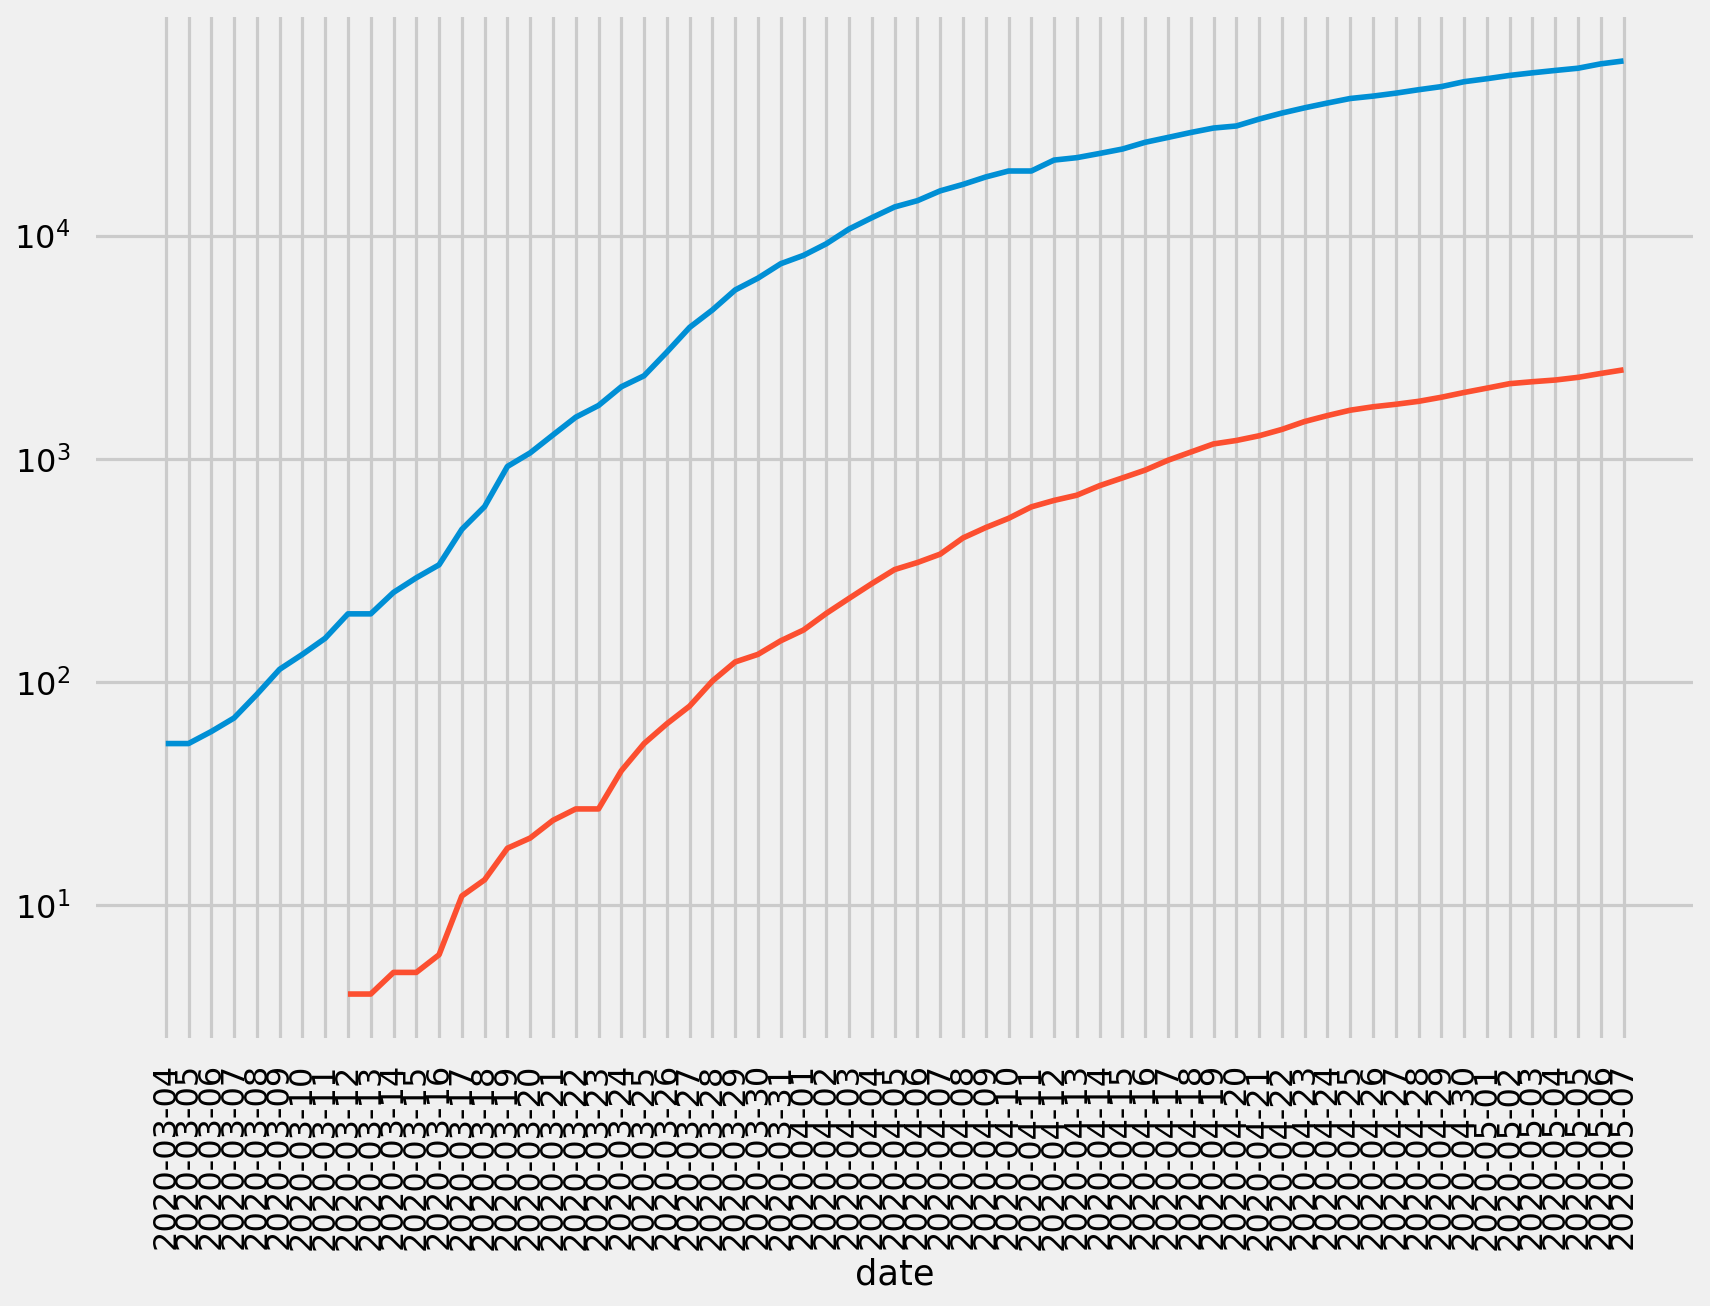

In [14]:
ax = sns.lineplot(x="date", y="positive", 
                  data=df_states.query('state == "CA"'))
ax = sns.lineplot(x="date", y="death", 
                  data=df_states.query('state == "CA"'))
ax.set(xticks=df_states.query('state == "CA"').date.values)
plt.xticks(rotation=90)
ax.set_ylabel('')
ax.set_yscale('log')
plt.show()

## New York

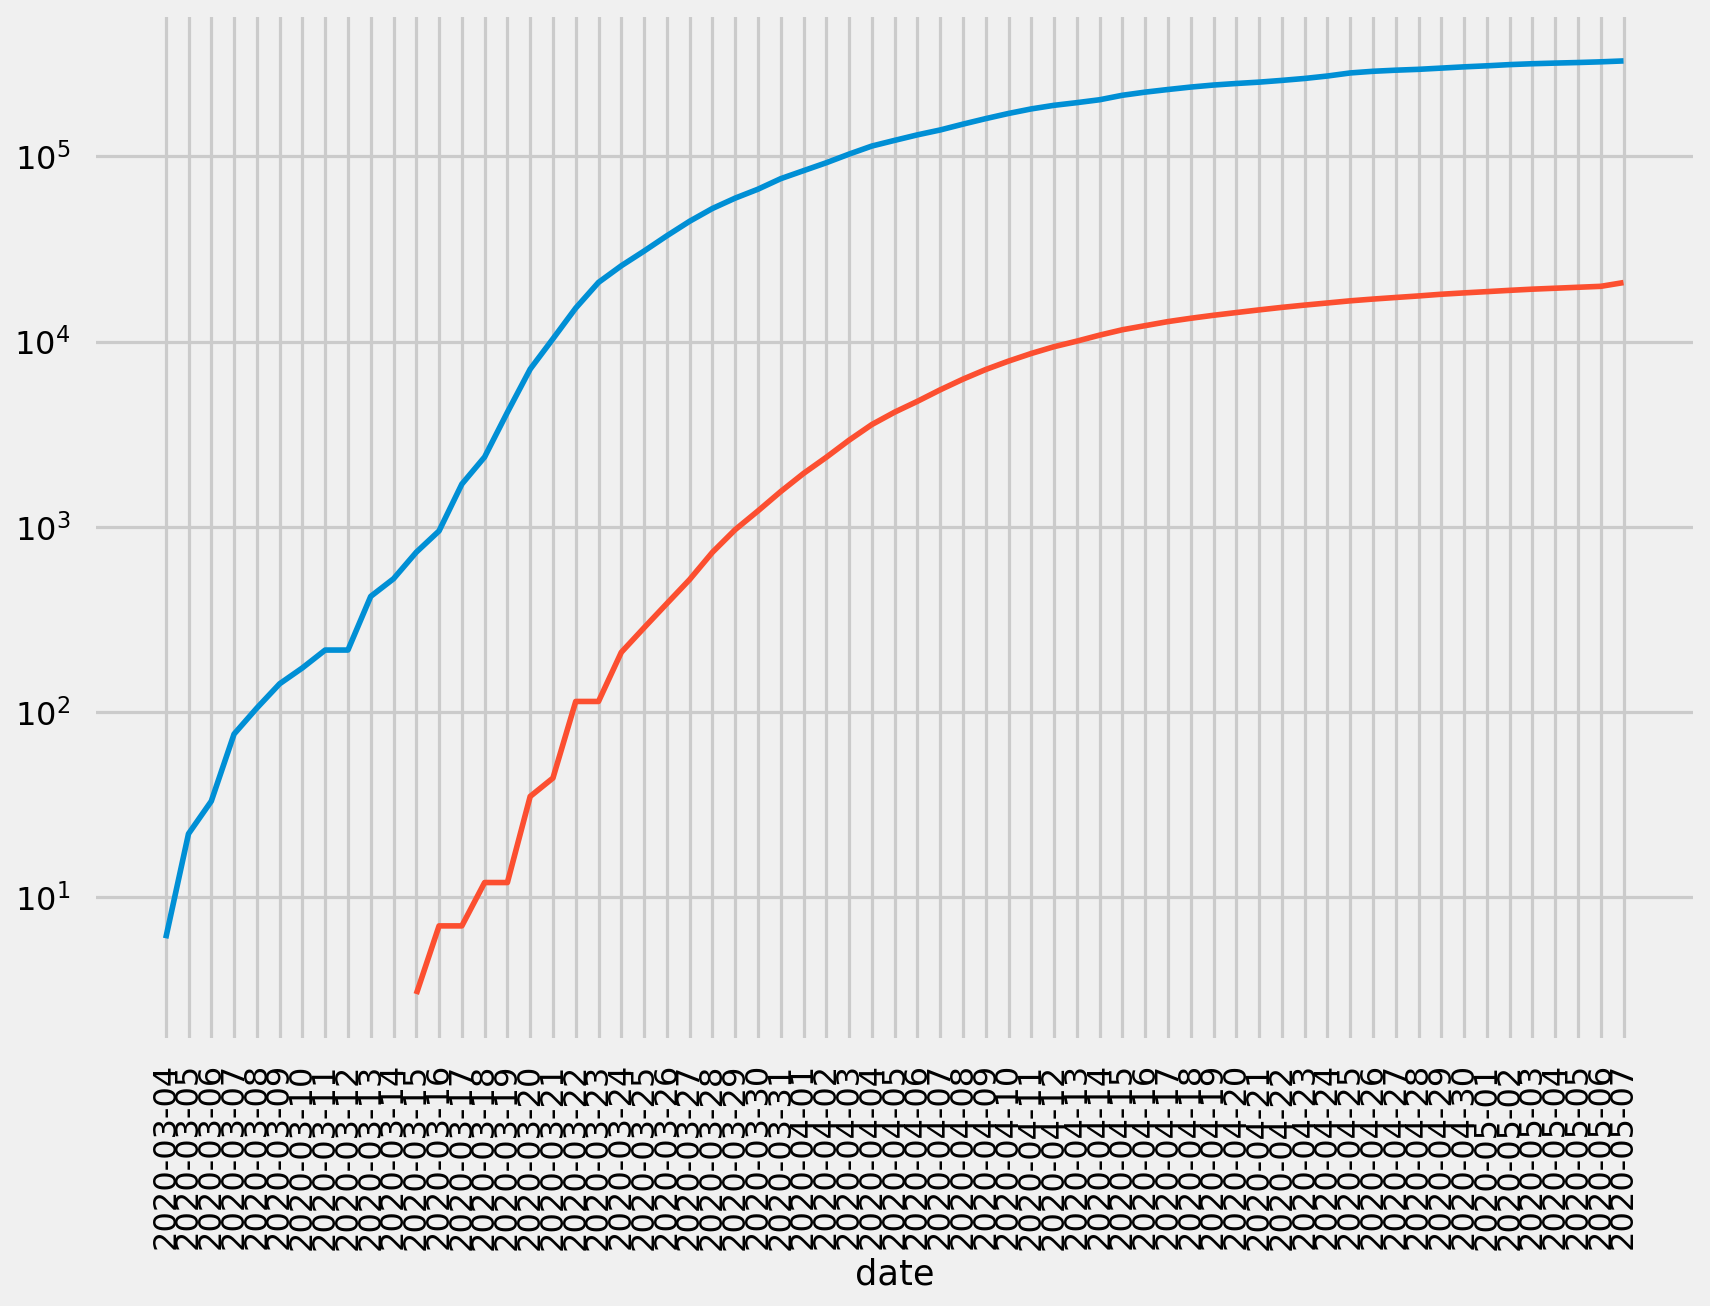

In [15]:
ax = sns.lineplot(x="date", y="positive", 
                  data=df_states.query('state == "NY"'))
ax = sns.lineplot(x="date", y="death", 
                  data=df_states.query('state == "NY"'))
ax.set(xticks=df_states.query('state == "NY"').date.values)
plt.xticks(rotation=90)
ax.set_ylabel('')
ax.set_yscale('log')
plt.show()

# Top 10 States by Deaths

In [16]:
latest_date = df_states['date'].max()
top_states = df_states.query('date == @latest_date').sort_values(by='death', 
                                                    ascending=False).state.head(10).tolist()
df_top_states = df_states.query('state == @top_states')
top_states

['NY', 'NJ', 'MA', 'MI', 'PA', 'IL', 'CT', 'CA', 'LA', 'FL']

In [17]:
df_states.query('date == @latest_date').sort_values(by='death', 
                                                    ascending=False)[['state', 'death']]

,state,death
2151,NY,20828.0
1960,NJ,8801.0
1204,MA,4552.0
1387,MI,4343.0
2407,PA,3416.0
888,IL,3111.0
382,CT,2797.0
253,CA,2504.0
1142,LA,2208.0
571,FL,1667.0


In [18]:
# Deaths per 100,000 people
df_states.query('date == @latest_date').sort_values(by='death_rate', 
                                                    ascending=False)[['state', 'death_rate']]

,state,death_rate
2151,NY,106.579558
1960,NJ,98.793066
382,CT,78.288896
1204,MA,65.950474
1142,LA,47.382198
1387,MI,43.447748
444,DC,40.571994
2523,RI,36.696727
2407,PA,26.672788
1261,MD,24.872913


# Deaths

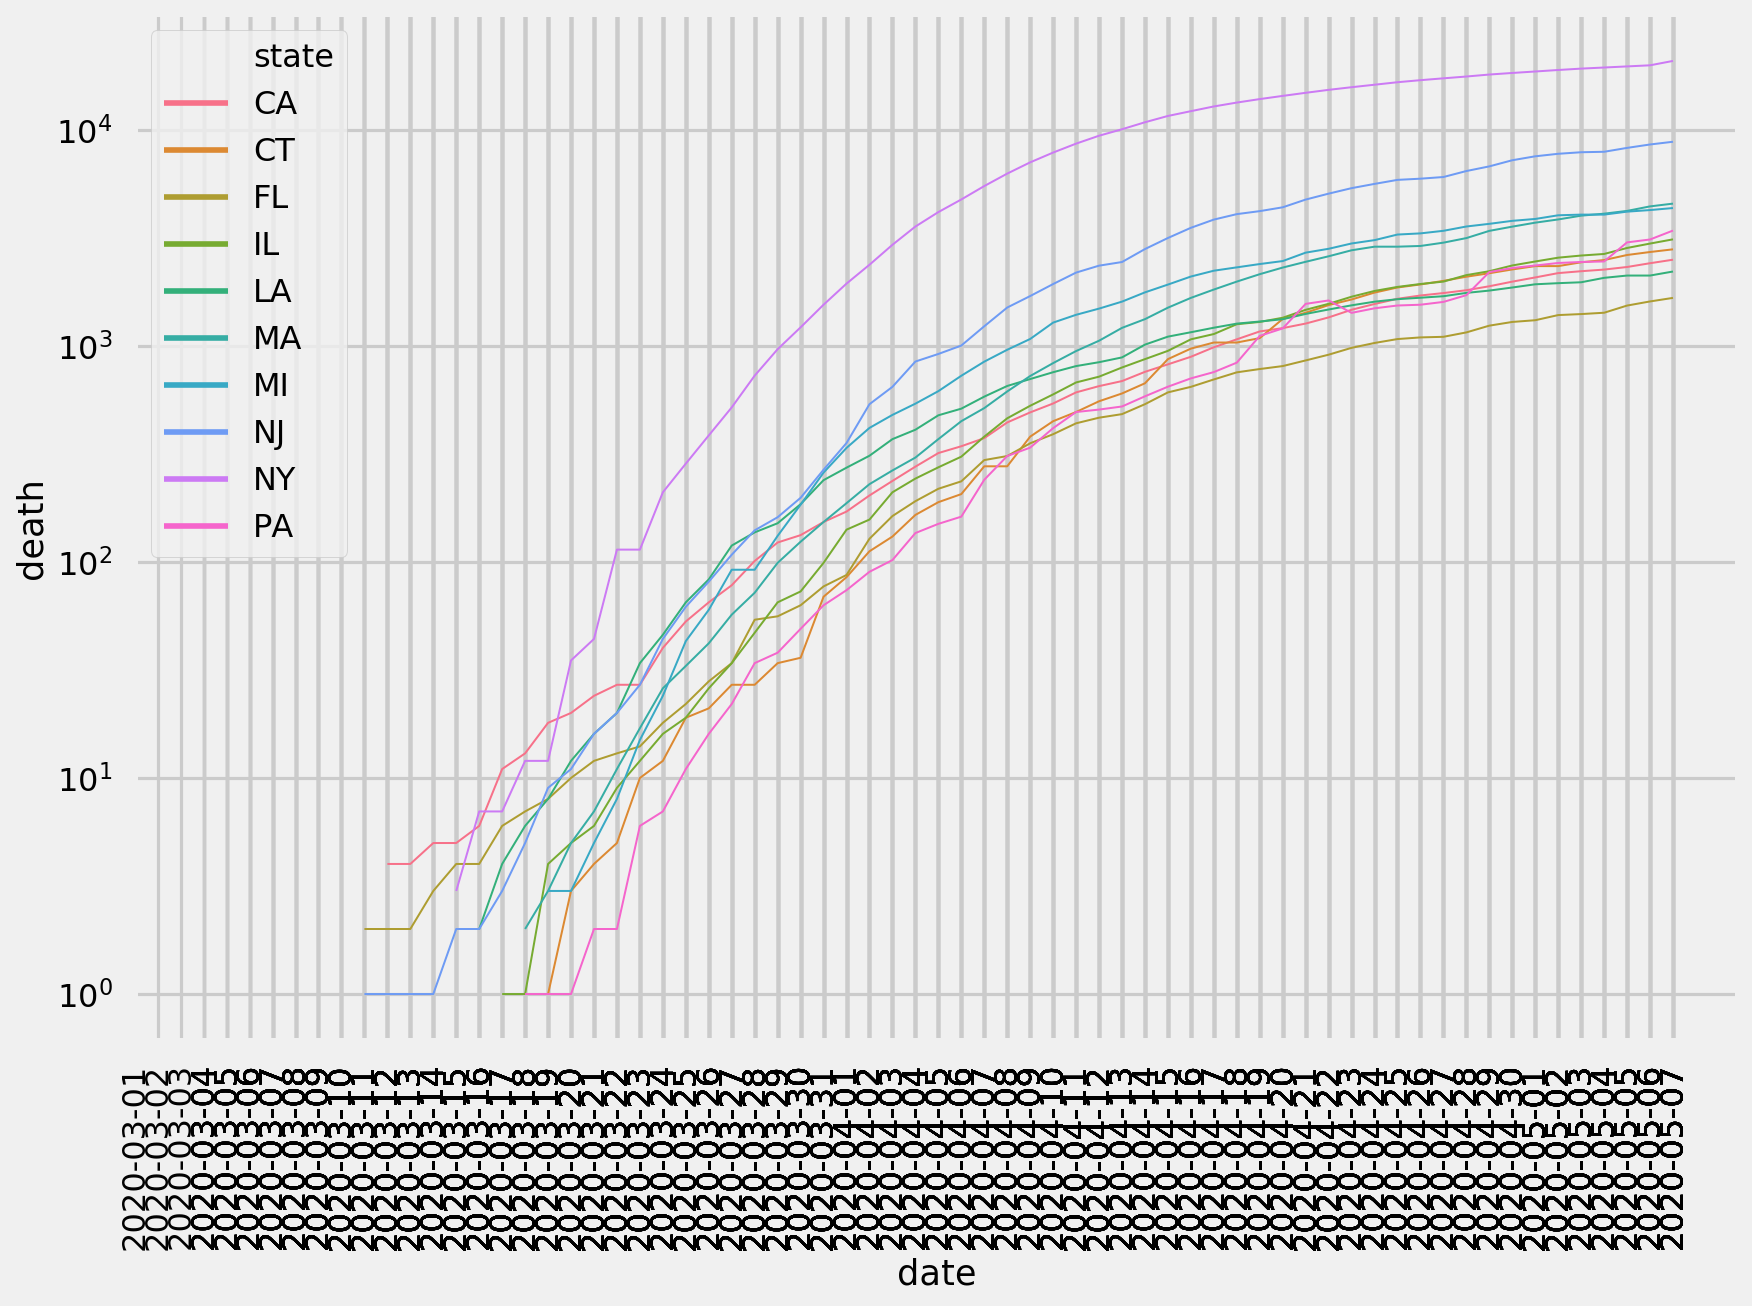

In [19]:
ax = sns.lineplot(x="date", 
                  y="death", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Deaths (7-day Moving Average)

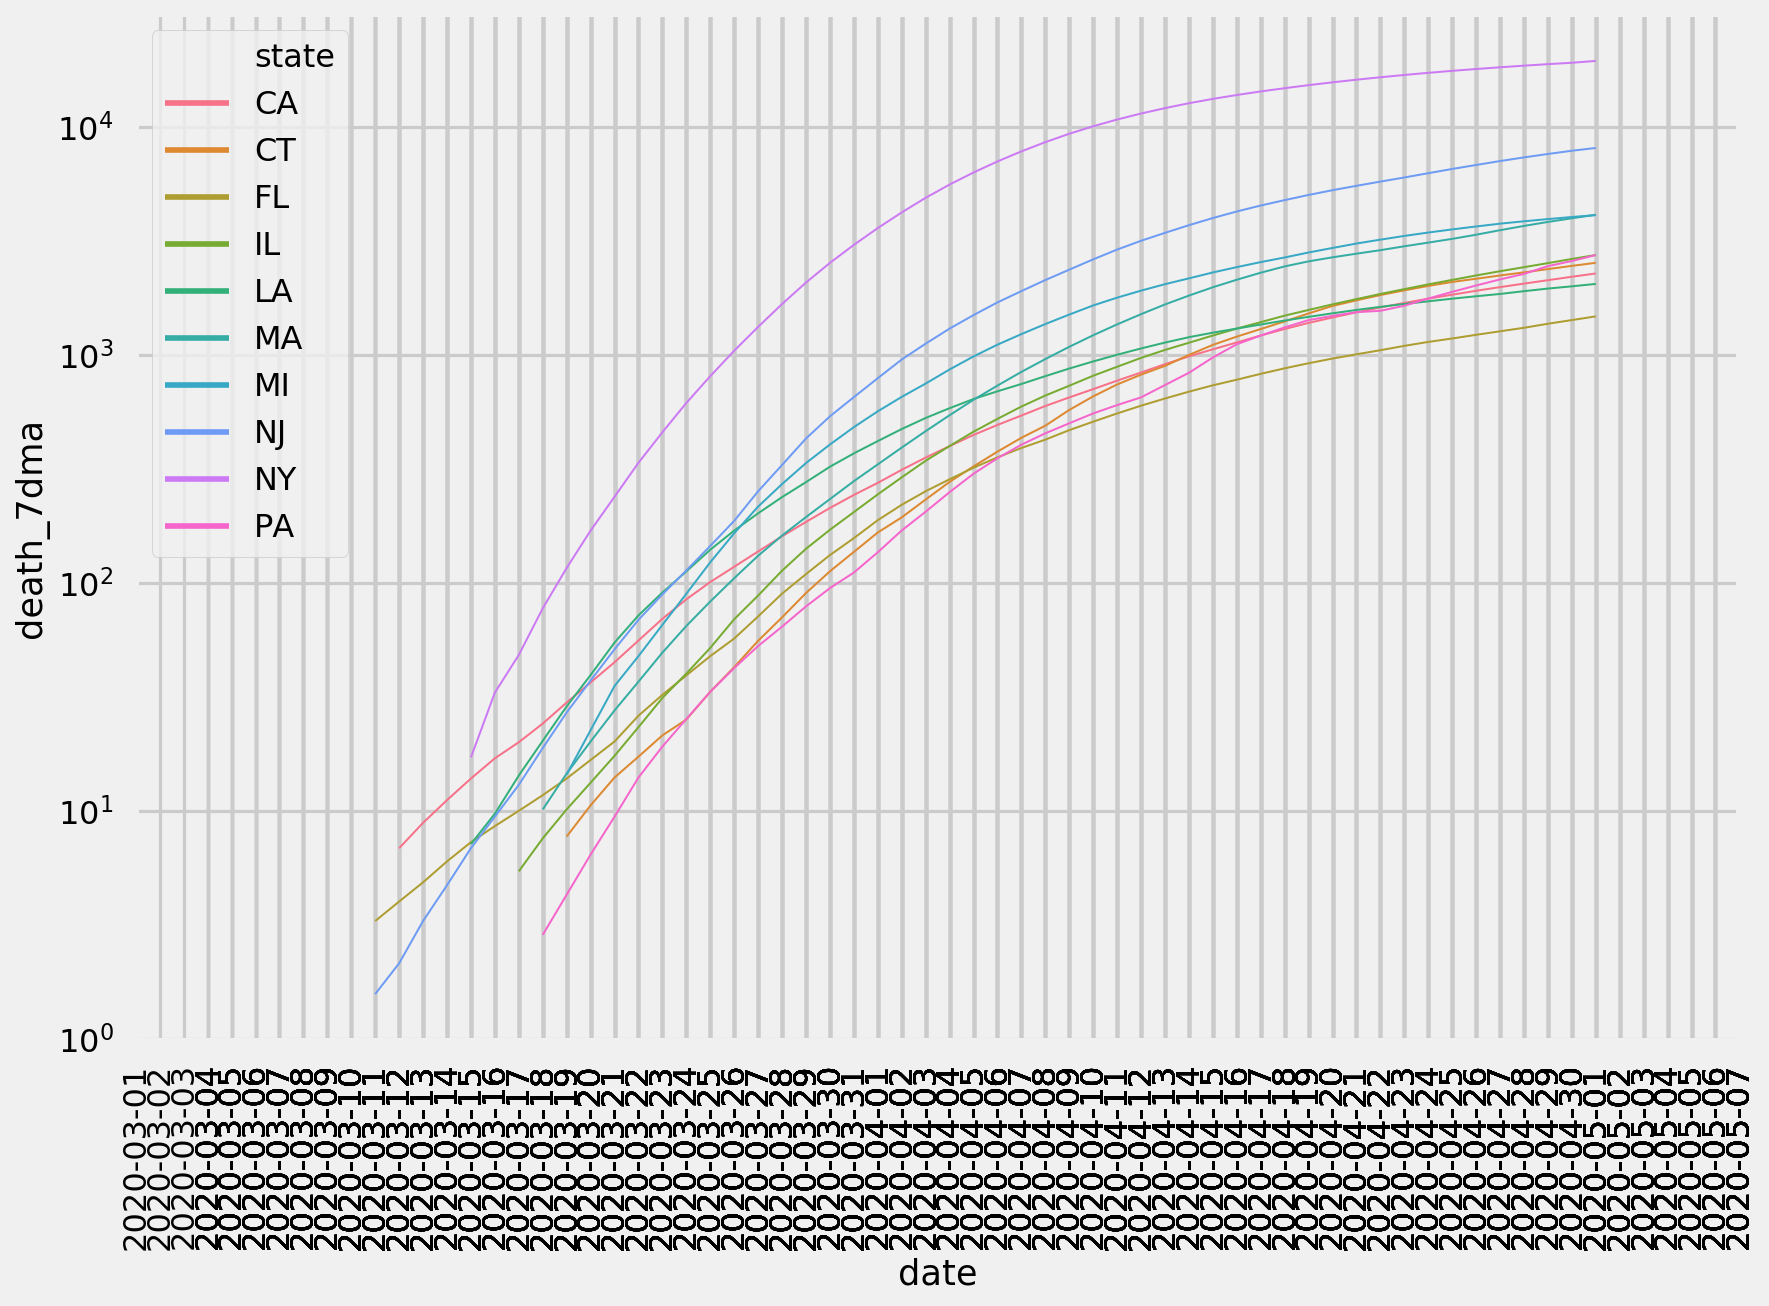

In [20]:
# TODO: index this by date first crossed 5 deaths
ax = sns.lineplot(x="date", 
                  y="death_7dma", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Positive Cases Per 100,000 People

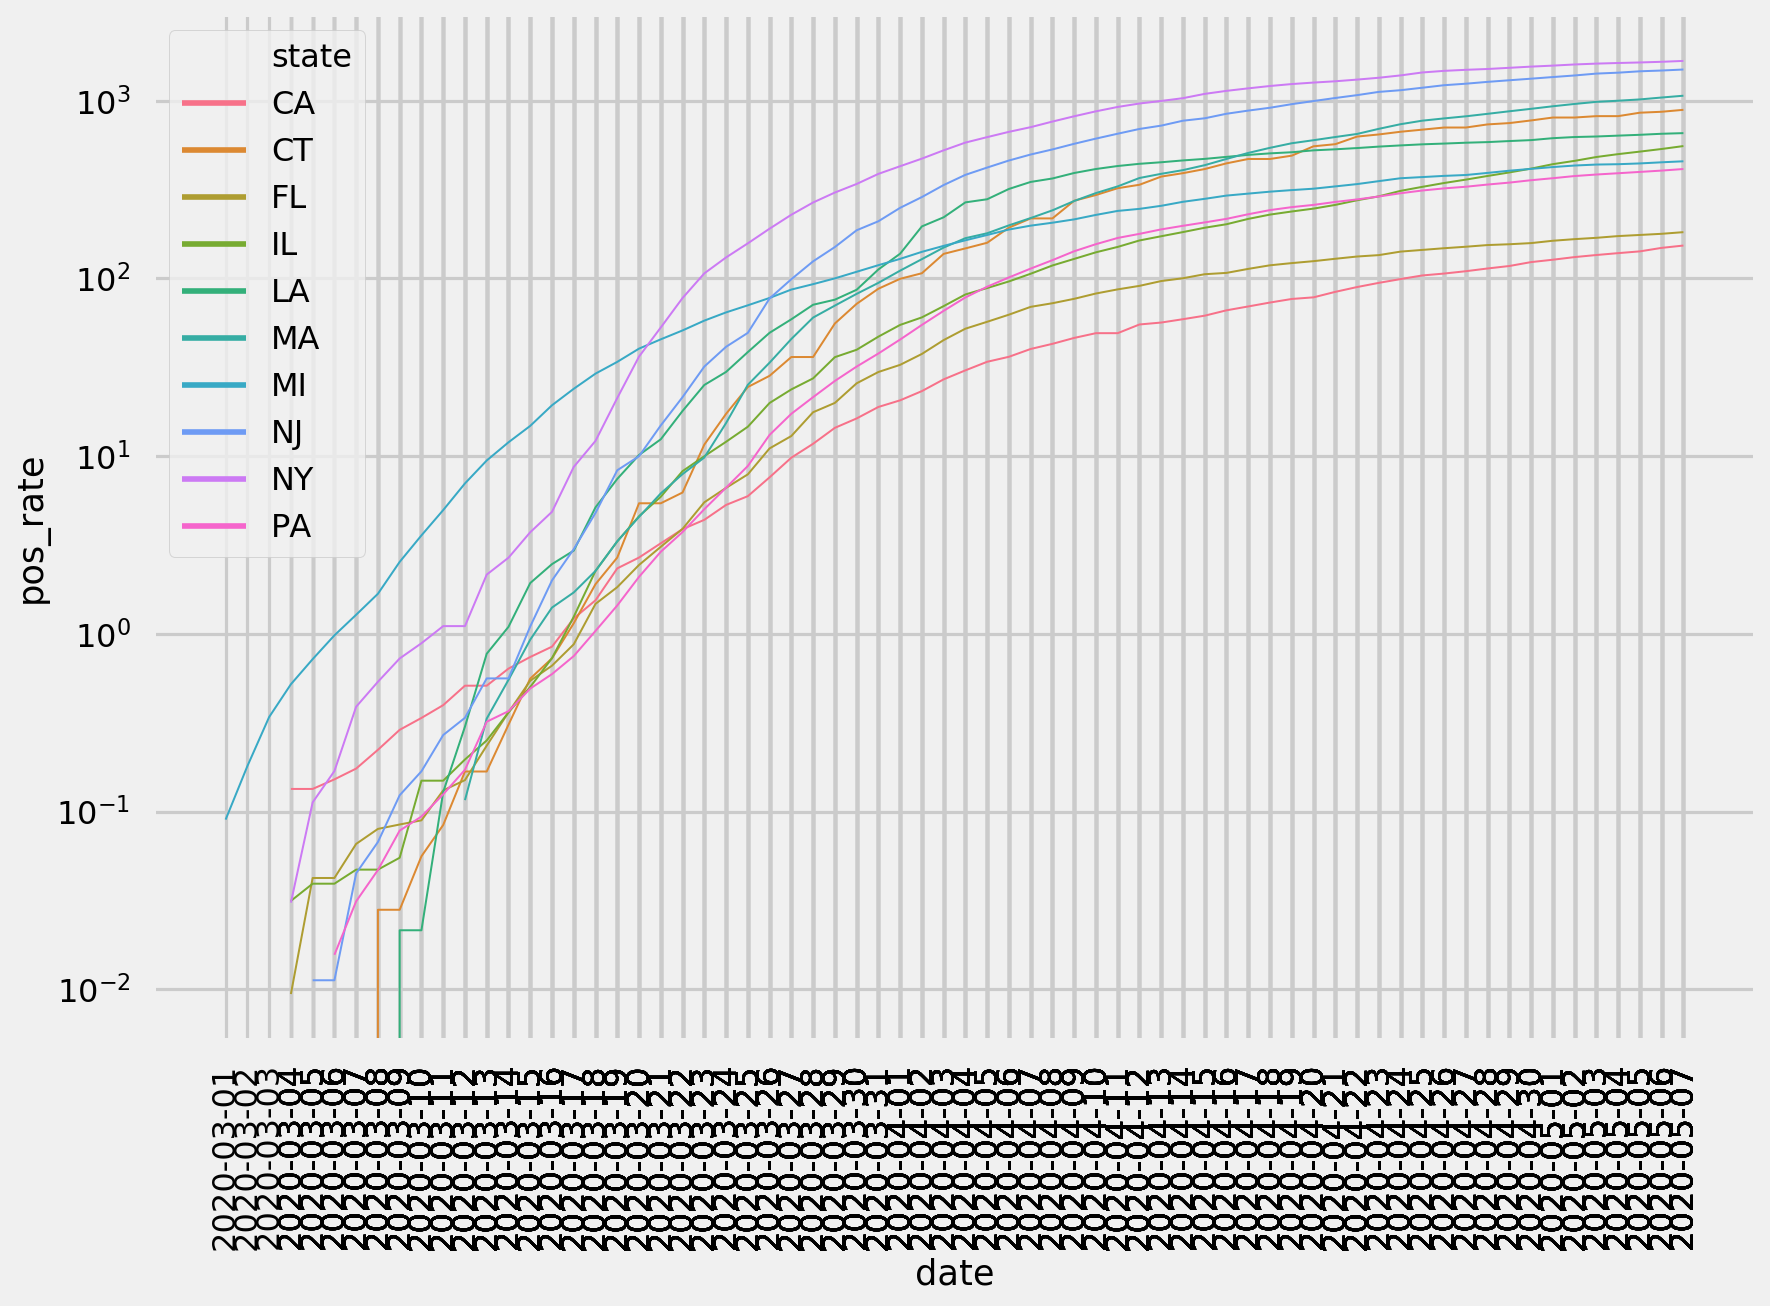

In [21]:
ax = sns.lineplot(x="date", y="pos_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Deaths Per 100,000 People

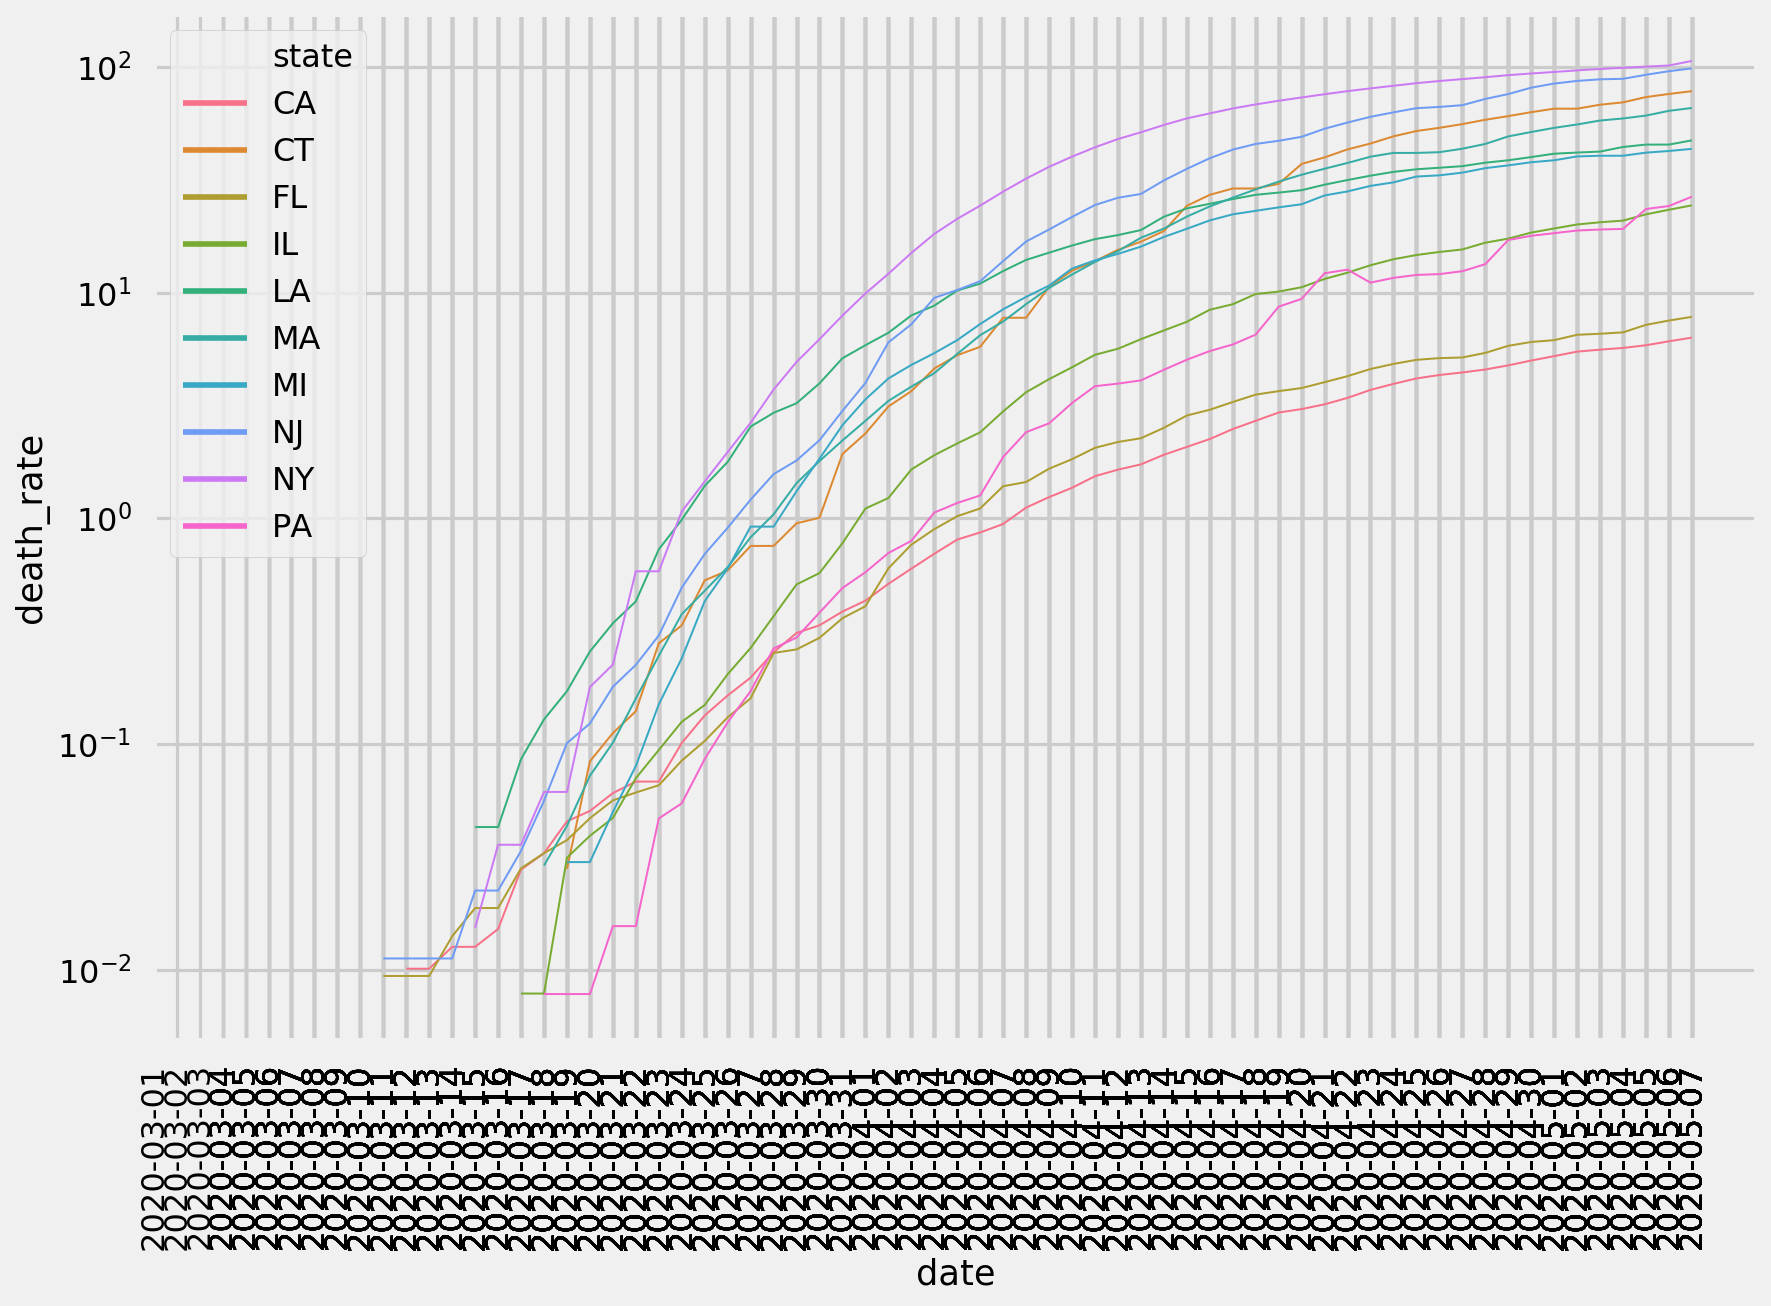

In [22]:
ax = sns.lineplot(x="date", y="death_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Tests Per 100,000 People

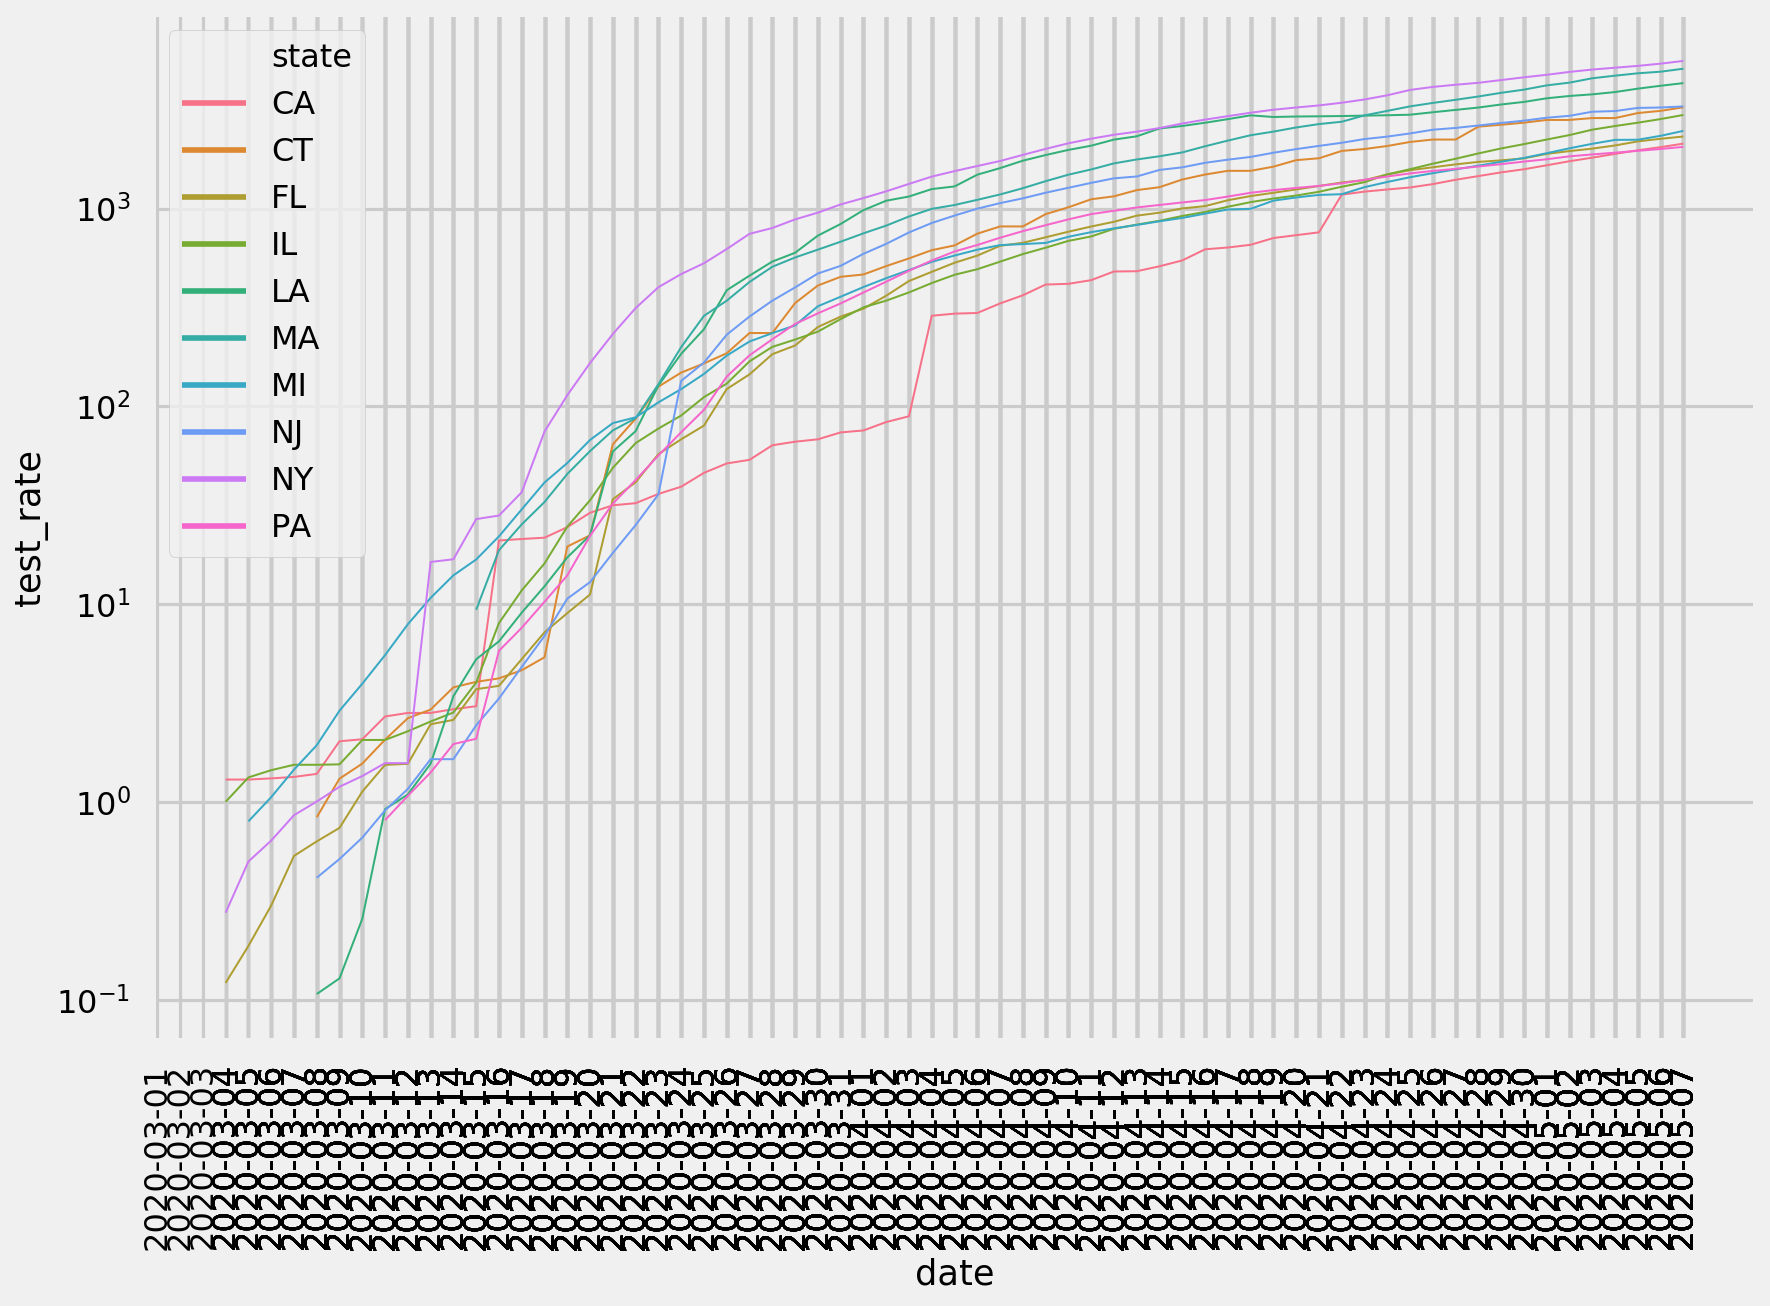

In [23]:
ax = sns.lineplot(x="date", y="test_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

In [24]:
df_states.query('date == @latest_date').sort_values(by='test_rate', 
                                                    ascending=False)[['state', 'test_rate']]

,state,test_rate
2523,RI,7785.570052
2151,NY,5577.240526
1769,ND,5376.692098
1204,MA,5094.529255
1142,LA,4308.325061
2847,UT,4256.201550
2024,NM,4089.093016
444,DC,3680.805176
2718,TN,3490.807251
0,AK,3300.752063
